# Benchmark de Prétraitement de Texte

Ce notebook démontre les résultats de l'étude de benchmark pour identifier la meilleure stratégie de nettoyage de texte pour la classification de produits Rakuten.

## Objectifs

1. Comparer différentes stratégies de prétraitement de texte
2. Identifier la configuration optimale pour la classification
3. Mesurer l'impact de chaque étape de nettoyage

## Méthodologie

- **Modèle** : Pipeline TF-IDF + Régression Logistique
- **Métrique** : F1 Score (pondéré)
- **Données** : 84,916 produits Rakuten avec 27 catégories
- **Division** : 85% train / 15% test

---

## 1. Importations et Configuration

In [1]:
import sys
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src')
sys.path.insert(0, '../scripts')

# Import preprocessing and benchmark modules
from rakuten_text.preprocessing import clean_text, final_text_cleaner, print_available_options
from rakuten_text.benchmark import define_experiments, run_benchmark, analyze_results, save_results

# Import data loading with consistent split
from load_data import split_data

## 2. Chargement des Données

In [2]:
# Load data with consistent split (85% dev, 15% holdout)
X_dev, X_holdout, y_dev, y_holdout = split_data()

# Create df_dev and df_holdout (needed by later cells)
df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

# Create text_raw column (required by run_benchmark)
df_dev["text_raw"] = (
    df_dev["designation"].fillna("").astype(str).str.strip() + " " +
    df_dev["description"].fillna("").astype(str).str.strip()
).str.strip()

df_holdout["text_raw"] = (
    df_holdout["designation"].fillna("").astype(str).str.strip() + " " +
    df_holdout["description"].fillna("").astype(str).str.strip()
).str.strip()

# Also create df for backward compatibility
df = df_dev.copy()

print(f"Development set: {len(df_dev):,} samples")
print(f"Hold-out set: {len(df_holdout):,} samples (will be evaluated at the end)")
print(f"Columns: {list(df_dev.columns)}")

Development set: 72,178 samples
Hold-out set: 12,738 samples (will be evaluated at the end)
Columns: ['designation', 'description', 'productid', 'imageid', 'prdtypecode', 'text_raw']


## 2b. Création du Hold-out Test Set

⚠️  Un hold-out test set (15%) qui NE SERA PAS utilisé pendant le benchmark. Ce set sera réservé pour l'évaluation finale uniquement.

## 3. Exploration des Options de Nettoyage

Voyons toutes les options de nettoyage disponibles :

In [3]:
# Afficher toutes les options de nettoyage disponibles
print_available_options()

Options de nettoyage disponibles :
  fix_encoding              : Corriger l'encodage de texte cassé avec ftfy
  unescape_html             : Décoder les entités HTML (&amp; → &)
  normalize_unicode         : Appliquer la normalisation Unicode NFC
  remove_html_tags          : Supprimer les balises HTML <tag>contenu</tag>
  remove_boilerplate        : Supprimer les phrases de template communes
  lowercase                 : Convertir en minuscules
  merge_dimensions          : Fusionner les motifs de dimensions (22 x 11 → 22x11)
  merge_units               : Fusionner les unités numériques (500 g → 500g)
  merge_durations           : Fusionner les durées (24 h → 24h)
  merge_age_ranges          : Fusionner les tranches d'âge (3-5 ans → 3_5ans)
  tag_years                 : Étiqueter les années à 4 chiffres (1917 → year1917)
  remove_punctuation        : Supprimer les signes de ponctuation isolés
  remove_stopwords          : Supprimer les mots vides français/anglais
  remove_single_letter

## 4. Benchmark Complet

Exécutons le benchmark complet pour comparer toutes les stratégies de nettoyage.


In [4]:
# Définir les expériences
experiments = define_experiments()

print(f"Nombre total d'expériences : {len(experiments)}")
print("\nExemples d'expériences :")
for exp in experiments[:5]:
    print(f"  - {exp['name']:30s} (Groupe: {exp['group']})")
print("  ...")

Nombre total d'expériences : 27

Exemples d'expériences :
  - baseline_raw                   (Groupe: 0_Baseline)
  - fix_encoding                   (Groupe: 1_Encodage)
  - unescape_html                  (Groupe: 1_Encodage)
  - normalize_unicode              (Groupe: 1_Encodage)
  - all_encoding_fixes             (Groupe: 1_Encodage)
  ...


In [5]:
# MODIFICATION IMPORTANTE: Utiliser SEULEMENT le development set
# Le hold-out test sera évalué à la fin

results_df = run_benchmark(
    df=df_dev,  # ✅ Utiliser development set uniquement
    experiments=experiments,
    test_size=0.15,  # Split interne pour le benchmark
    random_state=42,
    tfidf_max_features=10000,
    tfidf_ngram_range=(1, 2),
    verbose=True
)

print("\n⚠️  NOTE: Ces résultats sont sur un split interne du development set")
print("⚠️  L'évaluation finale sera effectuée sur le hold-out test set")

CONFIGURATION DU BENCHMARK
Total expériences      : 27
Taille de test         : 0.15
État aléatoire         : 42
TF-IDF max features    : 10,000
TF-IDF plage n-grammes : (1, 2)

Création de la division train/test...
  Train : 61,351 échantillons
  Test  : 10,827 échantillons

[1/27] baseline_raw
  Groupe : 0_Baseline
  Config : Aucune (données brutes)
  Nettoyage du texte... ✓ (longueur moyenne : 593 caractères)
  Entraînement... ✓
  Évaluation... ✓
  → Score F1 : 0.785795 | Exactitude : 0.7849 | [BASELINE]

[2/27] fix_encoding
  Groupe : 1_Encodage
  Config : {'fix_encoding': True}
  Nettoyage du texte... ✓ (longueur moyenne : 586 caractères)
  Entraînement... ✓
  Évaluation... ✓
  → Score F1 : 0.786723 | Exactitude : 0.7859 | Δ vs baseline : 🚀 +0.000929 (+0.12%)

[3/27] unescape_html
  Groupe : 1_Encodage
  Config : {'unescape_html': True}
  Nettoyage du texte... ✓ (longueur moyenne : 582 caractères)
  Entraînement... ✓
  Évaluation... ✓
  → Score F1 : 0.786143 | Exactitude : 0.7852 

In [10]:
# Analyser les résultats
analyze_results(results_df, top_n=10)


ANALYSE DES RÉSULTATS DU BENCHMARK

Score F1 Baseline : 0.785795

🚀 TOP 10 AMÉLIORATIONS :
--------------------------------------------------------------------------------
  traditional_cleaning           | F1 : 0.797581 | Δ : +0.011786 (+1.50%) | Groupe : 7_Combos
  lowercase_with_stopwords       | F1 : 0.796948 | Δ : +0.011153 (+1.42%) | Groupe : 8_AB_Tests
  traditional_without_stopwords  | F1 : 0.793313 | Δ : +0.007518 (+0.96%) | Groupe : 7_Combos
  minimal_cleaning_with_lowercase | F1 : 0.793313 | Δ : +0.007518 (+0.96%) | Groupe : 8_AB_Tests
  lowercase                      | F1 : 0.793002 | Δ : +0.007207 (+0.92%) | Groupe : 3_Casse
  lowercase_with_punctuation     | F1 : 0.793002 | Δ : +0.007207 (+0.92%) | Groupe : 8_AB_Tests
  lowercase_only                 | F1 : 0.793002 | Δ : +0.007207 (+0.92%) | Groupe : 8_AB_Tests
  remove_stopwords               | F1 : 0.788918 | Δ : +0.003124 (+0.40%) | Groupe : 6_Filtrage
  conservative_cleaning          | F1 : 0.786928 | Δ : +0.001133 

## 6. Analyse A/B : Impact de remove_stopwords

Cette analyse examine spécifiquement l'impact de `remove_stopwords` dans différents contextes.


🔬 ANALYSE A/B : IMPACT DE REMOVE_STOPWORDS

1️⃣  TEST ISOLÉ
--------------------------------------------------------------------------------
Remove_stopwords seul  : F1 = 0.788918 (Δ = +0.003124)
Baseline (aucun clean) : F1 = 0.785795
✅ Conclusion : remove_stopwords AMÉLIORE la performance en isolation

2️⃣  TEST DANS PIPELINE COMPLET (Traditional Cleaning)
--------------------------------------------------------------------------------
Avec remove_stopwords  : F1 = 0.797581
Sans remove_stopwords  : F1 = 0.793313
Différence             : +0.004268 (+0.54%)
✅ Conclusion : remove_stopwords AMÉLIORE la performance dans le pipeline complet

3️⃣  COMBINAISONS AVEC LOWERCASE
--------------------------------------------------------------------------------
Lowercase seul                 : F1 = 0.793002 (Δ = +0.007207)
Lowercase + stopwords          : F1 = 0.796948 (Δ = +0.011153)
Lowercase + punctuation        : F1 = 0.793002 (Δ = +0.007207)

Effet synergique (lowercase + stopwords) : +0.0039

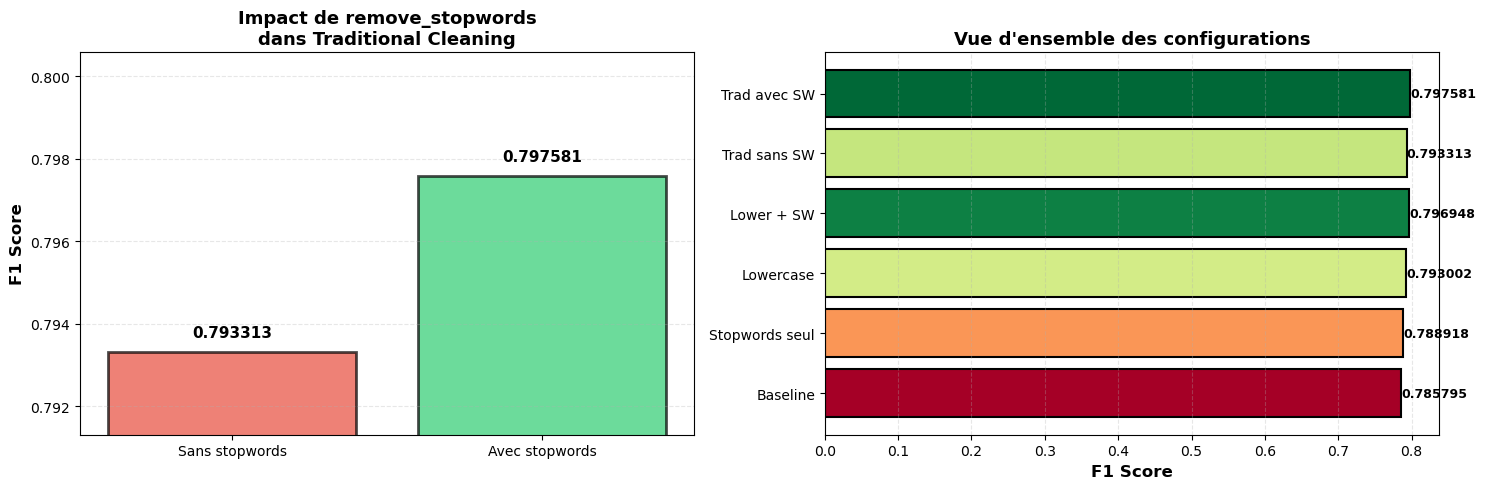

In [11]:
# Importer la fonction d'analyse
from rakuten_text.benchmark import analyze_stopwords_impact

# Analyser l'impact de remove_stopwords
evidence = analyze_stopwords_impact(results_df, show_plot=True)

---

## Notes

### Nouveaux tests ajoutés (v2.0)

Cette version du benchmark inclut 5 nouveaux tests A/B pour mieux comprendre l'impact de `remove_stopwords` :

1. **traditional_without_stopwords** : Identique à `traditional_cleaning` mais sans `remove_stopwords`
2. **lowercase_with_stopwords** : Combinaison de `lowercase` + `remove_stopwords`
3. **lowercase_with_punctuation** : Combinaison de `lowercase` + `remove_punctuation` (sans stopwords)
4. **lowercase_only** : `lowercase` seul (regroupé dans le groupe AB Tests)
5. **minimal_cleaning_with_lowercase** : Nettoyage minimal (encodage + HTML) + `lowercase`

**Total d'expériences : 27** (contre 22 dans la version précédente)

Ces tests permettent de répondre à la question : *"remove_stopwords améliore-t-il ou dégrade-t-il la performance dans un pipeline complet ?"*